In [87]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [89]:
# imdir = '/media/juliana/MAC/data/JR009/20150625/20150625_JR009_500um_0050Hz/V-Left_0'

In [845]:
# imdir = '/media/juliana/MAC/data/JR009/20150625/20150625_JR009_500um_0050Hz/H-Up_0'
imdir = '/media/juliana/MAC/data/JR009/20150625/20150625_JR009_500um_0050Hz/H-Down_0'

In [846]:
im_format = '.png'

In [847]:
target_freq = 0.05

In [848]:
reduce_factor = (2, 2)

In [849]:
sampling_rate = 60.0

In [850]:
cycle_dur = 1. / target_freq

In [851]:
from IPython.display import Image, display

In [852]:
display(cycle_dur)

20.0

In [853]:
basepath = os.path.split(os.path.split(imdir)[0])[0]
session = os.path.split(os.path.split(imdir)[0])[1]
cond = os.path.split(imdir)[1]

In [854]:
display(basepath); display(session); display(cond)

'/media/juliana/MAC/data/JR009/20150625'

'20150625_JR009_500um_0050Hz'

'H-Down_0'

In [855]:
files = os.listdir(imdir)
print len(files)
files = sorted([f for f in files if os.path.splitext(f)[1] == str(im_format)])
print len(files)
print files[0]

23973
23973
003_20150625174441758431_0_0_1deg_[0.0, 37.39484838995645].png


file: 003_20150625174441758431_0_0_1deg_[0.0, 37.39484838995645].png
sample type: float64, range: [3658.0, 1649.0]
sample shape: (246, 328)


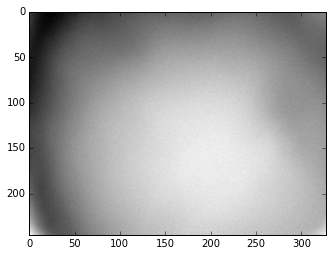

In [856]:
%matplotlib inline
tiff = TIFF.open(os.path.join(imdir, files[0]), mode='r')
sample = tiff.read_image().astype('float')
print "file: %s" % files[0]
print "sample type: %s, range: %s" % (sample.dtype, str([sample.max(), sample.min()]))
print "sample shape: %s" % str(sample.shape)
tiff.close()
plt.imshow(sample, cmap='gray')

In [857]:
# FIND CYCLE STARTS:
positions = [re.findall("\[([^[\]]*)\]", f) for f in files]
plist = list(itertools.chain.from_iterable(positions))
positions = [map(float, i.split(',')) for i in plist]

In [858]:
display(positions[0:10]); len(positions)

[[0.0, 37.39484838995645],
 [0.0, 37.305595814539764],
 [0.0, 37.2283681111874],
 [0.0, 37.148319545962764],
 [0.0, 37.06496388228396],
 [0.0, 36.985098086838335],
 [0.0, 36.9066841041656],
 [0.0, 36.82518372616807],
 [0.0, 36.74515470236634],
 [0.0, 36.66430149031588]]

23973

In [913]:
if 'H-Up' in cond:
    find_cycs = list(itertools.chain.from_iterable(
        np.where(np.diff([p[1] for p in positions]) < 0)))
    moveX = 0
    
    orientation=0
    direction=0
    
if 'H-Down' in cond:
    find_cycs = list(itertools.chain.from_iterable(
        np.where(np.diff([p[1] for p in positions]) > 0)))
    moveX = 0
    
    orientation=0
    direction=1
    
if 'V-Left' in cond:
    find_cycs = list(itertools.chain.from_iterable(
        np.where(np.diff([p[0] for p in positions]) < 0)))
    moveX = 1
    
    orientation=1
    direction=1
    
if 'V-Right' in cond:
    find_cycs = list(itertools.chain.from_iterable(
        np.where(np.diff([p[0] for p in positions]) > 0)))
    moveX = 1

    orientation=1
    direction=0
    
idxs = [i + 1 for i in find_cycs]
idxs.append(0)
idxs.append(len(positions))
idxs = sorted(idxs)
nframes_per_cycle = [idxs[i] - idxs[i - 1] for i in range(1, len(idxs))]

In [914]:
display(idxs)

[0,
 1199,
 2397,
 3596,
 4795,
 5994,
 7192,
 8390,
 9589,
 10788,
 11987,
 13185,
 14383,
 15582,
 16781,
 17980,
 19178,
 20376,
 21575,
 22774,
 23973]

In [915]:
display(nframes_per_cycle) # 0.05 cyc/sec, 20sec * 60Hz fps = 1200 frames per cycle (and, 1200*20 cycles=24k frames total )

[1199,
 1198,
 1199,
 1199,
 1199,
 1198,
 1198,
 1199,
 1199,
 1199,
 1198,
 1198,
 1199,
 1199,
 1199,
 1198,
 1198,
 1199,
 1199,
 1199]

In [916]:
positions[0:5]

[[0.0, 37.39484838995645],
 [0.0, 37.305595814539764],
 [0.0, 37.2283681111874],
 [0.0, 37.148319545962764],
 [0.0, 37.06496388228396]]

In [917]:
positions[1195:1202] # idx[1] = 1198, i.e., start of cycle 2

[[0.0, -58.793558513776745],
 [0.0, -58.873009341359335],
 [0.0, -58.9534533330241],
 [0.0, -59.03166040651304],
 [0.0, 37.39479091518317],
 [0.0, 37.30795917721678],
 [0.0, 37.21538455990488]]

In [918]:
from psychopy import visual, event, core, monitors, logging, tools

In [919]:
monitor_list = monitors.getAllMonitors()

In [920]:
monitor_list

[u'AQUOS', u'testMonitor', u'BenQtest', u'syncmaster2433BW']

In [921]:
# whichMonitor = 'AQUOS'
whichMonitor = 'syncmaster2433BW'

In [922]:
winsize = monitors.Monitor(whichMonitor).getSizePix()

In [923]:
winsize

[1920, 1200]

In [924]:
np.array(winsize)/2.

array([ 960.,  600.])

In [925]:
win = visual.Window(fullscr=True, rgb=-1, size=winsize, units='deg', monitor=whichMonitor)

In [926]:
win.close()

8635.5372 	WARNING 	Use of rgb arguments to stimuli are deprecated. Please use color and colorSpace args instead
8635.5376 	WARNING 	User requested fullscreen with size [1920 1200], but screen is actually [2560, 1440]. Using actual size


In [927]:
cyc_per_sec = 0.05
screen_width_cm = monitors.Monitor(whichMonitor).getWidth()
screen_height_cm = (float(screen_width_cm)/monitors.Monitor(whichMonitor).getSizePix()[0])*monitors.Monitor(whichMonitor).getSizePix()[1]
display(screen_width_cm); display(screen_height_cm)

total_length = max([screen_width_cm, screen_height_cm])
print "Total Length:  ", total_length

51.52

32.2

Total Length:   51.52


In [928]:
fps = 60.
total_time = total_length/(total_length*cyc_per_sec)
frames_per_cycle = fps/cyc_per_sec
print "frames per cycle: ", frames_per_cycle
distance = monitors.Monitor(whichMonitor).getDistance()

num_seq_reps = 1
duration = total_time*num_seq_reps
print "cycle duration (s): ", duration

frames per cycle:  1200.0
cycle duration (s):  20.0


In [929]:
barWidth = 1
# orientation=0
# longside = tools.monitorunittools.cm2deg(screen_height_cm, monitors.Monitor(whichMonitor))

width_deg = tools.monitorunittools.cm2deg(screen_width_cm, monitors.Monitor(whichMonitor))
height_deg = tools.monitorunittools.cm2deg(screen_height_cm, monitors.Monitor(whichMonitor))

if orientation==1:
    angle = 90 #0 is horizontal, 90 is vertical. 45 goes from up-left to down-right.
    longside = tools.monitorunittools.cm2deg(screen_height_cm, monitors.Monitor(whichMonitor)) #screen_height_cm
    # travelDist = screen_width_cm*0.5 # Half the travel distance (magnitude, no sign)
#     width_deg = tools.monitorunittools.cm2deg(screen_width_cm, monitors.Monitor(whichMonitor))
    travelDist = (width_deg*0.5)
else:
    angle = 0
    longside = tools.monitorunittools.cm2deg(screen_width_cm, monitors.Monitor(whichMonitor)) #screen_width_cm
    # travelDist = screen_height_cm*0.5 # Half the travel distance (magnitude, no sign)
#     height_deg = tools.monitorunittools.cm2deg(screen_height_cm, monitors.Monitor(whichMonitor))
    travelDist = (height_deg*0.5)

In [930]:
total_length_deg = tools.monitorunittools.cm2deg(total_length, monitors.Monitor(whichMonitor))
stimSize = (longside,barWidth) # First number is longer dimension no matter what the orientation is.
# uStartPoint = travelDist + barWidth*0.5 
uStartPoint = travelDist

In [931]:
print "screen physical dim [W, H]: ", width_deg, height_deg
print 'total (max) travel distance: ', total_length_deg
print "size", stimSize
print "visible travel distance", travelDist*2

screen physical dim [W, H]:  147.579490117 92.2371813234
total (max) travel distance:  147.579490117
size (147.5794901174449, 1)
visible travel distance 92.2371813234


In [932]:
# [screen_width, screen_height_cm] = [93.0, 52.517647058823535]
# winsize (pixels) = [1360, 768]
# [width_deg, height_deg] = [213.11945001432255, 120.34980706691158]
# Looks like aspect ratio is constant, phew.

# 213.11945001432255/120.34980706691158
# 1360/768.
# 93.0/52.517647058823535

In [933]:
# orientation=0
# direction=0 # as of 04/2016, this means FROM neg TO pos (left-->right {cond1: V-Left} or bottom-->top {cond4: H-Up})

if direction==1: # START FROM NEG, go POS (start left-->right, or start bottom-->top)
    startSign = -1
else:
    startSign = 1

In [934]:
startPoint = startSign*uStartPoint +barWidth*0.5; display(startPoint)

-45.618590661701525

In [935]:
endPoint = -1*(startPoint + startSign*(total_length_deg*0.5-uStartPoint - barWidth*0.5)); display(endPoint)

72.78974505872245

In [936]:
dist = endPoint - startPoint
print "DIST: ", dist
print "START: ", startPoint
print "END: ", endPoint

# THESE VALS ARE ACTUALLY INCORRECT -- we fall short of this.

DIST:  118.40833572
START:  -45.6185906617
END:  72.7897450587


In [937]:
startPoint + startSign*(total_length_deg*0.5-uStartPoint + barWidth*0.5) # should be ADDING barWidth (to start AND end off screen...)
# This formulation follows the leading edge of the bar, with the edge starting offscreen and ending at the opposite side, with the caaveat
# that at the end of the cycle (V-Left), we have the cycle ending w/ the bar ON screen...

# ACTUALLY, this is wrong:  startPoint adds barWidth, thereby starting the trailing edge of the bar aligned to edge of screen... 
# and, endPoint results in the leading edge of the bar aligned to the edge of opposite side of screen... -- see Line 

-73.78974505872245

In [938]:
dist = endPoint - startPoint; display(dist)

118.40833572042396

In [939]:
total_length_deg - dist

29.171154397020928

In [940]:
# 04/12/2016 - jyr

# signs got screwed up at some point...

# SHOULD BE THIS:
#startPoint = startSign*uStartPoint - barWidth*0.5; display(startPoint)
# i.e., total_length_deg*0.5 + barWidth*0.5 -- this starts with bar OFF screen (leading edge)


#endPoint = -1*(startPoint + startSign*(total_length_deg*0.5-uStartPoint + barWidth*0.5)); display(endPoint)
# i.e., -1*total_length_deg*0.5 + barWidth*0.5 -- this starts with bar OFF screen (leading edge)

# SIMPLIFIED:
# endPoint = -1*(startPoint - startSign*(barWidth*0.5)); display(endPoint) 
# THIS is if you just want the leading edge to go from screen-end to screen-end

1260

[-45.618590661701525,
 -45.519917048601172,
 -45.42124343550082,
 -45.322569822400467,
 -45.223896209300115]

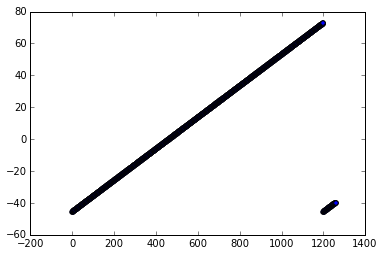

In [941]:
# STH WERID WITH POSITIONS:
# Just using linearly spaced 1/fps intervals for x frames should give similar coords, using the same end/startPoints...
# But, compare below 2 figs...

# SOLVED:
# Running with monitor settings to syncmaster:
# winsize = [1920, 1200]
# startPoint = -73.2897450587
# posX = -73.2896754026,-72.8982859728, ...
# DIST:  146.079490117
# DUR:  20.0

# i.e,. datafiles from 06.25.2015 using some other config...

import math
# angle = 0 # VERT 

nframes = 21
dt = 1/fps
samples = np.arange(0,nframes,dt)
pos = []
for i in samples:
    curr_pos = (i % total_time) / total_time * (endPoint-startPoint) + startPoint
    if angle==90:
        cart_pos = curr_pos*math.sin(angle*math.pi/180)+0 #centerPoint[0]
    else:
        cart_pos= curr_pos*math.cos(angle*math.pi/180) #+centerPoint[1]
    pos.append(cart_pos)
    
display(len(pos))
plt.scatter(np.arange(len(samples)), pos)
display(pos[0:5])

1199

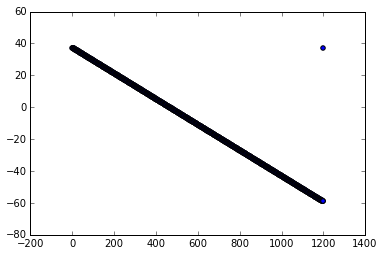

In [942]:
if moveX:
    moving_dim = [positions[i][0] for (i,p) in enumerate(positions)]
else:
    moving_dim = [positions[i][1] for (i,p) in enumerate(positions)]
    
display(idxs[1])

nframes = idxs[1] + 1
real_pos = moving_dim[0:nframes]
plt.scatter(np.arange(len(real_pos)), real_pos)

In [943]:
len(positions)

23973

In [944]:
stimSize

(147.5794901174449, 1)

In [945]:
display(startPoint); display(endPoint); display(moving_dim[0]); display(moving_dim[-1])

-45.618590661701525

72.78974505872245

37.39484838995645

-59.01741815769583

In [946]:
# More weird stuff... why are timestamps so off?

from datetime import datetime
tstamps = [f.split('_')[1] for f in files]
FORMAT = '%Y%m%d%H%M%S%f'
#date = datetime.strptime(tstamps[0], FORMAT)
#display(date)
# convert string into math-able form:
#'{hrs}:{min}:{sec}.{msec}'.format(hrs = str(d.hour), min = str(d.minute), sec = str(d.second), msec = str(d.microsecond/1000))
fmt_tstamps = [datetime.strptime(t, FORMAT) for t in tstamps]
times = ['{hrs}:{min}:{sec}.{msec}'.format(hrs = str(d.hour), min = str(d.minute), sec = str(d.second), msec = str(d.microsecond)) for d in fmt_tstamps]

In [947]:
mstimes = []
for t in times:
    hours, minutes, seconds = (t.split(":"))[-3:]
    hours = int(hours)
    minutes = int(minutes)
    seconds = float(seconds)
    miliseconds = int(3600000 * hours + 60000 * minutes + 1000 * seconds)
    mstimes.append(miliseconds)

In [948]:
t

'17:51:22.391440'

In [949]:
tstamps[0:5]

['20150625174441758431',
 '20150625174441775092',
 '20150625174441791601',
 '20150625174441808601',
 '20150625174441825288']

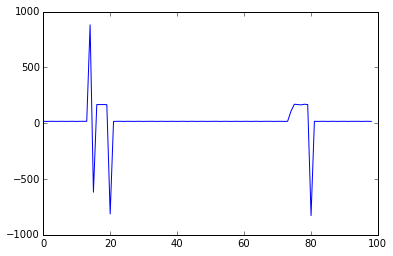

In [950]:
plt.plot(np.diff(mstimes[0:100]))

In [951]:
# x = [positions[i][0] for (i,p) in enumerate(positions)]
P = [i for i in moving_dim]
display(P[0])
display(P[idxs[1]-1])
display(P[idxs[1]])
# sim = np.zeros((len(P), ))
print "travel distance: ", abs(P[idxs[1]-1]) + abs(P[0])

37.39484838995645

-59.03166040651304

37.39479091518317

travel distance:  96.4265087965


In [953]:
# shift all position values by some max value so there are no "negative" values
# this makes it so that we actually draw within rect (need positive)


print abs(moving_dim[-1])
print P[0:5]
print P[idxs[1]-5:idxs[1]+1]

# shift_val = np.ceil(max([abs(i) for i in P]))

if direction==0:
    shift_val = abs(moving_dim[0])
else:
    shift_val = abs(moving_dim[-1])

shift_P = [i+shift_val for i in P] # so we actually draw within rect (need positive)
shift_P = np.flipud(shift_P)

if direction==0: # shift by offset between calculate travel dist and actual screen size (andddd start from bottom of screen)
    shift_screen = abs(travelDist*2 - max(shift_P))
    shift_P -= shift_screen

print shift_P[0:5]
print shift_P[idxs[1]-5:idxs[1]+1]
print max(shift_P) - min(shift_P)


59.0174181577
[37.39484838995645, 37.305595814539764, 37.2283681111874, 37.148319545962764, 37.06496388228396]
[-58.71341454042849, -58.793558513776745, -58.873009341359335, -58.9534533330241, -59.03166040651304, 37.39479091518317]
[ 0.          0.07987959  0.16010173  0.24041583  0.32142307]
[  9.60857328e+01   9.61656503e+01   9.62446391e+01   9.63258785e+01
   9.64122528e+01  -1.75527958e-03]
96.4265087965


In [968]:
import pygame
import sys

# travelDist*2

# Set "screen" dimensions to be s.t. it is physical screen, not actual bar travel distance...

if moveX:
#     w=abs(np.ceil(abs(P[0])+barWidth)*2) # include offset to compensate for stupid positioning above...
#     w=abs(np.ceil(max(shift_P) - min(shift_P)) + barWidth)
    w=np.ceil(abs(travelDist)*2)
    h=abs(np.ceil(stimSize[0]))
else:
#     h=abs(np.ceil(abs(P[0])+barWidth)*2) # include offset to compensate for stupid positioning above...
#     h=abs(np.ceil(max(shift_P) - min(shift_P)) + barWidth)
    h=np.ceil(abs(travelDist)*2)
    w=abs(np.ceil(stimSize[0]))

display(w,h)

black = (0,0,0)
white = (255,255,255)
print stimSize

148.0

93.0

(147.5794901174449, 1)


In [969]:
pygame.init()
screen = pygame.display.set_mode((int(w),int(h)))

screen.fill(black)
# pygame.display.update()

barw = stimSize[0]
barh = stimSize[1]

posx = 0.
posy=shift_P[1199]
print actual_nframes
screen.fill(black)
pygame.draw.rect(screen, white, (posx,posy,barw,2), 0)
pygame.display.update()

23976


In [970]:
pygame.init()
screen = pygame.display.set_mode((int(w),int(h)))

screen.fill(black)

savedir = './tests/simulation/%s/' % cond
if not os.path.exists(savedir):
    os.makedirs(savedir)

if moveX:
    barw = stimSize[1]
    barh = stimSize[0]
else:
    barw = stimSize[0]
    barh = stimSize[1]    

actual_nframes = len(positions)

delay_secs = 5 # n seconds to wait to simulate hemo "delay"
delay_frames = delay_secs * fps


nframes = 0
while nframes < actual_nframes:
    if moveX:
        posx=shift_P[nframes]
        posy=0 #shift_x[nframes]
    else:
        posx=0
        posy=shift_P[nframes]
        
    screen.fill(black)
    pygame.draw.rect(screen, white, (posx,posy,barw,2), 0)
    pygame.display.update()
    pygame.image.save(screen, os.path.join(savedir, "screen_%i.bmp" % nframes))
    nframes += 1

In [971]:
nframes_collected = os.listdir(savedir)
print("N frames: %s" % str(len(nframes_collected)))
print("N positions: %s" % str(len(positions)))

N frames: 23973
N positions: 23973


In [972]:
sim_frames = sorted([i for i in nframes_collected if i.split('.')[1]=='bmp'], key=natural_keys)

In [975]:
from PIL import Image
sim=Image.open(os.path.join(savedir, sim_frames[1190]),'r')

SIM IMAGE SHAPE: (148, 93)


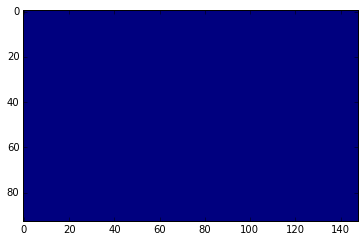

In [976]:
# is it working...?
# sim = Image.open(os.path.join("./stimuli/simulated", sim_frames[100])).convert('LA')
# sim=sim.convert('1') # make BW so don't have to deal with 3d
# lena = misc.imread(os.path.join("./stimuli/simulated", sim_frames[100]))

# sim=Image.open(os.path.join(savedir, sim_frames[100]),'r')
sim=sim.convert('L') #makes it greyscale
y=np.asarray(sim.getdata(),dtype=np.float64).reshape((sim.size[1],sim.size[0]))
y=np.asarray(y,dtype=np.uint8)

plt.imshow(y)
print "SIM IMAGE SHAPE: %s" % str(sim.size)

In [977]:
y.max()

0

In [978]:
stack = np.empty((sim.size[1], sim.size[0], len(sim_frames)))
print stack.shape

for i, f in enumerate(sim_frames):
    if i % 1000 == 0:
        print('%d images processed...' % i)
    sim=Image.open(os.path.join(savedir, sim_frames[i]),'r')
    sim=sim.convert('L') #makes it greyscale
    y=np.asarray(sim.getdata(),dtype=np.float64).reshape((sim.size[1],sim.size[0]))
    stack[:, :, i] = y

(93, 148, 23973)
0 images processed...
1000 images processed...
2000 images processed...
3000 images processed...
4000 images processed...
5000 images processed...
6000 images processed...
7000 images processed...
8000 images processed...
9000 images processed...
10000 images processed...
11000 images processed...
12000 images processed...
13000 images processed...
14000 images processed...
15000 images processed...
16000 images processed...
17000 images processed...
18000 images processed...
19000 images processed...
20000 images processed...
21000 images processed...
22000 images processed...
23000 images processed...


In [979]:
freqs = fft.fftfreq(len(stack[0, 0, :]), 1 / sampling_rate) # When set fps to 60 vs 120 -- target_bin should be 2x higher for 120, but freq correct (looks for closest matching target_bin )
binwidth = freqs[1] - freqs[0]
#target_bin = int(target_freq / binwidth)
target_bin = np.where(freqs == min(freqs, key=lambda x: abs(float(x) - target_freq)))[0][0]
print "TARGET: ", target_bin, freqs[target_bin]
print "FREQS: ", freqs

TARGET:  20 0.0500563133525
FREQS:  [ 0.          0.00250282  0.00500563 ..., -0.00750845 -0.00500563
 -0.00250282]


In [980]:

# FFT:
sample = stack[:,:,0]
mag_map = np.empty(sample.shape)
phase_map = np.empty(sample.shape)

ft_real = np.empty(sample.shape)
ft_imag = np.empty(sample.shape)

ft_real_shift = np.empty(sample.shape)
ft_imag_shift = np.empty(sample.shape)

dynrange = np.empty(sample.shape)

ft = np.empty(sample.shape)
ft = ft + 0j

#dlist = []
i = 0
for x in range(sample.shape[0]):
    for y in range(sample.shape[1]):

        # THIS IS BASICALLY MOVING AVG WINDOW...
        pix = scipy.signal.detrend(stack[x, y, :], type='constant')

        #dynrange[x, y] = np.log2(pix.max() - pix.min())

        curr_ft = fft.fft(pix)  # fft.fft(pix) / len(pix)])
        #curr_ft_shift = fft.fftshift(curr_ft)

# DF = pd.DataFrame.from_records(dlist)

        #mag = np.abs(curr_ft)
        # mag_max = np.where(mag == mag.max())
        # mag_min = np.where(mag == mag.min())
        
        phase = np.angle(curr_ft)

        ft_real[x, y] = curr_ft[target_bin].real
        ft_imag[x, y] = curr_ft[target_bin].imag
        
        ft[x,y] = curr_ft[target_bin]

        #ft_real_shift[x, y] = curr_ft_shift[target_bin_shift].real
        #ft_imag_shift[x, y] = curr_ft_shift[target_bin_shift].imag

        # if i % 100 == 0:
        # print ft_real[x, y], ft_imag[x,y]

        #mag_map[x, y] = mag[target_bin]
        phase_map[x, y] = phase[target_bin]

        #dlist.append((x, y, curr_ft))

        i += 1

In [981]:
os.path.split(os.path.split(savedir)[0])[0]

'./tests/simulation'

In [982]:
outdir = os.path.join(os.path.split(os.path.split(savedir)[0])[0], "structs")
append_to_name = "simulated"
outdir

D = dict()

D['ft_real'] = ft_real  # np.array(ft)
D['ft_imag'] = ft_imag
D['ft'] = ft

# D['mag_map'] = mag_map
D['phase_map'] = phase_map

D['mean_intensity'] = np.mean(stack, axis=2)
#D['stack'] = stack
#del stack
D['dynrange'] = dynrange
D['target_freq'] = target_freq
D['fps'] = sampling_rate
D['freqs'] = freqs  # fft.fftfreq(len(pix), 1 / sampling_rate)
# D['freqs_shift'] = freqs_shift #fft.fftfreq(len(pix), 1 / sampling_rate)

D['binsize'] = freqs[1] - freqs[0]
# np.where(freqs == min(freqs, key=lambda x: abs(float(x) - target_freq)))[0][0]
D['target_bin'] = target_bin
#D['target_bin_shift'] = target_bin_shift
D['nframes'] = nframes_per_cycle
D['reduce_factor'] = reduce_factor

# SAVE condition info:
sessionpath = os.path.split(imdir)[0]
# outdir = os.path.join(sessionpath, 'structs')
# if not os.path.exists(outdir):
#     os.makedirs(outdir)

reduce_factor = (1, 1)
fext = 'D_target_FFT_%s_%s_%s.pkl' % (cond, str(reduce_factor), append_to_name)
fname = os.path.join(outdir, fext)
with open(fname, 'wb') as f:
    # protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(D, f, protocol=pkl.HIGHEST_PROTOCOL)

In [989]:
# outdir = "./tests/simulation/V-Left_0/structs"
os.listdir(outdir)

cond = 'H-Up_0'

reduce_factor = (1, 1)
fext = 'D_target_FFT_%s_%s_%s.pkl' % (cond, str(reduce_factor), append_to_name)
fname = os.path.join(outdir, fext)
with open(fname, 'rb') as f:
    # protocol=pkl.HIGHEST_PROTOCOL)
    if 'Down' in cond:
        downD = pkl.load(f)
    else:
        upD = pkl.load(f)

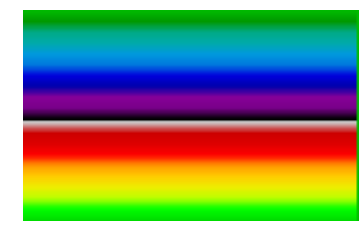

In [1072]:
#####################################################
# H-DOWN STIMULATION:
# ---------------------------------------------------
phase_mapD = downD['phase_map']
# plt.imshow(phase_map, cmap='spectral', vmin=-1*np.pi, vmax=np.pi)
plt.imshow(phase_mapD, cmap='spectral')
plt.axis('off')
# plt.colorbar()

legend_path = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation/H-Down_legend.tif'
plt.savefig(legend_path)

#####################################################
# THIS MAP GOES:
# from 0 @ TOP EDGE to -pi, to +pi, back to 0 (BOTTOM)

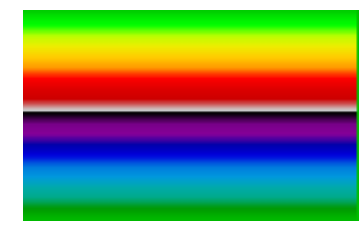

In [1073]:
#####################################################
# H-UP_0 STIMULATION:
# ---------------------------------------------------
phase_mapU = upD['phase_map']
fig = plt.figure()
plt.imshow(phase_mapU, cmap='spectral')
plt.axis('off')

# plt.colorbar()

legend_path = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation/H-Up_legend.tif'
plt.savefig(legend_path)
#####################################################
# THIS IS GOING:
# 0 (BOTTOM edge) to -pi, to pi, back to 0 (TOP)

In [1074]:
#####################################################
# TEST MERGE:
#####################################################

flist = os.listdir(outdir)
flist = [f for f in flist if os.path.splitext(f)[1] == '.pkl']
dstructs = [f for f in flist if 'D_target_FFT' in f and str(reduce_factor) in f and append_to_name in f]
if not dstructs:
    dstructs = [f for f in flist if 'D_' in f and str(reduce_factor) in f]

print dstructs
    
D = dict()
for f in dstructs:
    outfile = os.path.join(outdir, f)
    with open(outfile,'rb') as fp:
        D[f] = pkl.load(fp)

['D_target_FFT_H-Down_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Right_0_(1, 1)_simulated.pkl', 'D_target_FFT_H-Up_0_(1, 1)_simulated.pkl']


In [1075]:
for d in D.keys():
    if "Down" in d:
        downkey = d
    elif "Up" in d:
        upkey = d
        

In [1076]:
# print min([D[upkey].shape, D[upkey].shape])
downmap = np.zeros(D[downkey]['ft'].shape)
upmap = np.zeros(D[upkey]['ft'].shape)

downmap = downmap + 0j
upmap = upmap + 0j

downmap = D[downkey]['ft']
upmap = D[upkey]['ft']

In [1077]:
downmap

array([[  64471.70412651 -2011.47410271j,   64471.70412651 -2011.47410271j,
          64471.70412651 -2011.47410271j, ...,
          64471.70412651 -2011.47410271j,   64471.70412651 -2011.47410271j,
              0.00000000    +0.j        ],
       [ 127151.30601943 -8092.49736011j,  127151.30601943 -8092.49736011j,
         127151.30601943 -8092.49736011j, ...,
         127151.30601943 -8092.49736011j,  127151.30601943 -8092.49736011j,
              0.00000000    +0.j        ],
       [ 126335.67344119-16499.78720637j,  126335.67344119-16499.78720637j,
         126335.67344119-16499.78720637j, ...,
         126335.67344119-16499.78720637j,  126335.67344119-16499.78720637j,
              0.00000000    +0.j        ],
       ..., 
       [ 115958.44509692+52169.17167454j,  115958.44509692+52169.17167454j,
         115958.44509692+52169.17167454j, ...,
         115958.44509692+52169.17167454j,  115958.44509692+52169.17167454j,
              0.00000000    +0.j        ],
       [ 119429.050

<matplotlib.colorbar.Colorbar instance at 0x7f41aab93998>

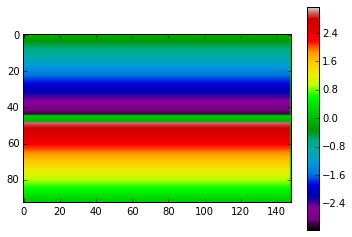

In [1078]:
#########################################################################
# STIM MAPS:
#########################################################################

azimuth_phase = np.angle( (downmap / upmap) ) / 2.
azimuth_phase = ( np.angle(downmap) - np.angle(upmap) ) / 2. 
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f41aad94c68>

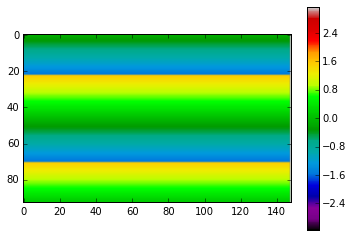

In [1079]:
azimuth_phase = np.angle( (downmap / upmap) ) / 2.
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2. 
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x7f41a9d119e0>

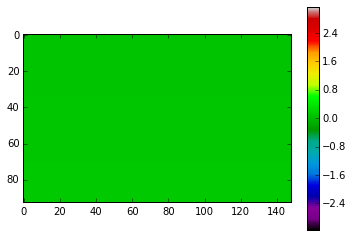

In [1084]:
#########################################################################
# DELAY MAP:
#########################################################################
delay_map = np.angle(downmap * upmap) / 2
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2. 
plt.imshow(delay_map, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f41aa2273f8>

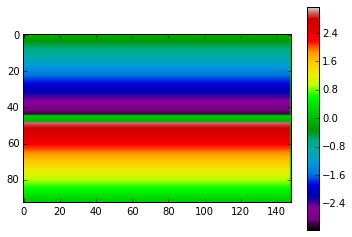

In [1094]:
# azimuth_phase = np.angle(leftmap / rightmap) / 2. 
azimuth_phase = ( np.angle(downmap) - np.angle(upmap) ) / 2
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f41a8d87a28>

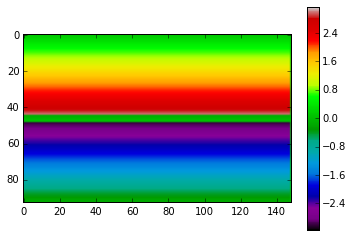

In [1101]:
# azimuth_phase = np.angle(leftmap / rightmap) / 2. 
azimuth_phase = ( np.angle(upmap) - np.angle(downmap) ) / 2. 
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

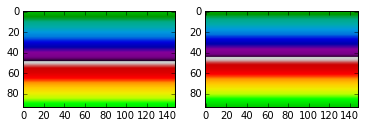

In [1120]:
# azimuth_phase = np.angle(leftmap / rightmap) / 2. 
onedir_map = np.angle(downmap) + delay_map
azimuth_phase = np.angle(upmap.conjugate())  + delay_map
# fig=plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
# cbar = plt.colorbar(fig) 
# cbar.ax.invert_yaxis()
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(onedir_map, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)

fig.add_subplot(1,2,2)
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)


In [1172]:
###########################################################################################################

In [838]:
# DONT DO THIS.

# ftmap = dict()
# # outshape = D[D.keys()[0]]['ft_real'].shape
# # print outshape
# for curr_key in D.keys():
#     outshape = D[curr_key]['ft_real'].shape # WTF, outshape changing based on stim... (but maybe not for actual imaging acquis. data)
#     print outshape
#     reals = D[curr_key]['ft_real'].ravel()
#     imags = D[curr_key]['ft_imag'].ravel()
# #     imags = imags*-1.
# #     if 'Down' in curr_key:
# #         imags = imags*-1
# #     if 'Right' in curr_key:
# #         imags = imags*-1
#     ftmap[curr_key] = [complex(x[0], x[1]) for x in zip(reals, imags)]
#     ftmap[curr_key] = np.reshape(np.array(ftmap[curr_key]), outshape)


(93, 120)
(93, 122)


In [822]:
# WTF, why multipling by -1.... imags are just imags!

i = 2
j = -3
c = complex(2,3)
# c = 2-3j
# print c
print c.real
print c.imag

c = 2-3j
print type(c)
cr = c.real
ci = c.imag
print cr, ci

2.0
3.0
<type 'complex'>
2.0 -3.0


In [ ]:
###########################################################################################################

In [1191]:
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')

rgba = cmap(0.5)
print(rgba)

from matplotlib import cm


(0.99807766255210428, 0.99923106502084169, 0.74602077638401709, 1.0)


(0.80000000000000004, 0.80000000000000004, 0.80000000000000004, 1.0)

In [1234]:
# map_shape = leftmap.shape
# screen_legend = np.zeros(map_shape)

screen_size = [int(i*0.25) for i in winsize]
print screen_size
screen_legend = np.zeros((screen_size[1], screen_size[0]))

VERT = 1
left = 1

if VERT: 
    if left:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    if right:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end

if HORZ:
    if up:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[0]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    if right:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end

plt.imshow(screen_legend, cmap='spectral')

[480, 300]


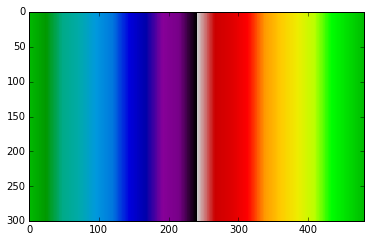

In [1235]:
###################################################
# V-LEFT:
###################################################

plt.imshow(screen_legend, cmap='spectral')

In [1233]:
screen_legend[i][240]

0.0

In [1221]:
screen_legend[i].shape

(480,)

In [1240]:
screen_size = [int(i*0.25) for i in winsize]
print screen_size
screen_legend = np.zeros((screen_size[1], screen_size[0]))

VERT = 1
left = 0

HORZ = 0
up = 1

if VERT: 
    if left:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    else:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end

if HORZ:
    if up:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[0]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    else:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end


[480, 300]


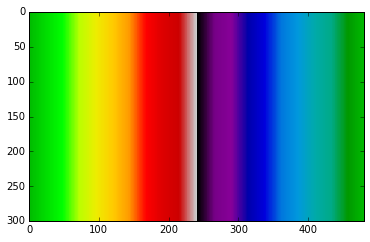

In [1241]:
###################################################
# V-RIGHT:
###################################################

plt.imshow(screen_legend, cmap='spectral')
